## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [1]:
#%pip install nltk
#%pip install pydot
#%pip install graphviz
#%conda install pydot-ng 

In [2]:
#nltk init
#import nltk
#nltk.download('punkt')

In [3]:
# set path
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Usser/anaconda3/envs/dl_env/Lib/site-packages/graphviz'

In [4]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
%matplotlib inline

# nltk
from nltk import sent_tokenize

# keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation
from keras.utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

np.random.seed(1234)

In [5]:
# We'll use Alice in Wonderland

path = get_file('carrol-alice.txt', origin="http://www.gutenberg.org/files/11/11-0.txt")
corpus = open(path, encoding='utf-8').read()

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer

# Split document into sentences first
corpus = corpus[corpus.index('\n\n')+2:]  # remove header.
sentences = sent_tokenize(corpus)

# Tokenize using Keras
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n“”' + "'"
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)  # tokenizer assigns a unique integer index to each unique word in the text
                                   # also characters in base_filter will be removed from the text

# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)
nb_samples = sum(len(s) for s in corpus)

print(len(sequences), tokenizer.document_count)

985 985


In [7]:
print("Word Index:", tokenizer.word_index)
print("Word Counts:", tokenizer.word_counts)
print("Document Count:", tokenizer.document_count)
print("Word Document Frequency:", tokenizer.word_docs)

Word Index: {'the': 1, 'and': 2, 'to': 3, 'a': 4, 'she': 5, 'it': 6, 'of': 7, 'said': 8, 'i': 9, 'alice': 10, 'in': 11, 'you': 12, 'was': 13, 'that': 14, 'as': 15, 'her': 16, 'at': 17, 'on': 18, 'with': 19, 'all': 20, 'had': 21, 'but': 22, 'for': 23, 'so': 24, 'be': 25, 'very': 26, 'not': 27, 'what': 28, 'this': 29, 'little': 30, 'they': 31, 'he': 32, 'out': 33, 'down': 34, 'is': 35, 'one': 36, 'up': 37, 'his': 38, 'about': 39, 'if': 40, 'then': 41, 'no': 42, 'were': 43, 'like': 44, 'would': 45, 'went': 46, 'herself': 47, 'them': 48, 'again': 49, 'know': 50, 'do': 51, 'have': 52, 'when': 53, 'could': 54, 'or': 55, 'there': 56, 'thought': 57, 'off': 58, 'time': 59, 'me': 60, 'queen': 61, 'into': 62, 'see': 63, 'how': 64, 'did': 65, 'your': 66, 'who': 67, 'king': 68, 'well': 69, 'don’t': 70, 'by': 71, 'began': 72, 'my': 73, 'now': 74, 'mock': 75, 'its': 76, 'an': 77, 'i’m': 78, 'turtle': 79, 'quite': 80, 'hatter': 81, 'gryphon': 82, 'way': 83, 'it’s': 84, 'are': 85, 'their': 86, 'much': 

In [8]:
# To understand what is happening;

print(sentences[324])  # this is a sentence
print(sentences[324].split())
print(sequences[324])  # this is the same sentence where words are encoded as numbers.
print(list(tokenizer.word_index[word.lower().replace(',', '').replace('.', '').replace('“', '').replace('”', '')] 
           for word in sentences[324].split()))

Alice thought she might as well wait, as she had nothing else to do,
and perhaps after all it might tell her something worth hearing.
['Alice', 'thought', 'she', 'might', 'as', 'well', 'wait,', 'as', 'she', 'had', 'nothing', 'else', 'to', 'do,', 'and', 'perhaps', 'after', 'all', 'it', 'might', 'tell', 'her', 'something', 'worth', 'hearing.']
[10, 57, 5, 159, 15, 69, 1990, 15, 5, 21, 129, 360, 3, 51, 2, 223, 107, 20, 6, 159, 139, 16, 220, 700, 779]
[10, 57, 5, 159, 15, 69, 1990, 15, 5, 21, 129, 360, 3, 51, 2, 223, 107, 20, 6, 159, 139, 16, 220, 700, 779]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

#### In the context of Word2Vec and skip-gram models:
- *Target Word* is the word for which you are trying to predict the context words.
- *Context words* are the words that appear in the vicinity (context) of the target word.

- *couples* This is a list of tuples, where each tuple contains a pair of words (integer indices) representing a skip-gram pair. For example, (2, 45) might represent a target word at index 2 and a context word at index 45. The pairs are generated based on the specified window size around each target word.
- *labels* This is a list of binary labels associated with each skip-gram pair. A label of 1 typically indicates that the context word is a true context word (a positive sample), and a label of 0 indicates a negative sample (a randomly selected word that is not the actual context).

In [9]:
# Let's first see how Keras' skipgrams function works.
# The integer indices assigned to actual words start from 1 and padding token at index 0 allows us to represent sequences with variable lengths while still maintaining a consistent input size for the neural network.

couples, labels = skipgrams(sequences[324], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

index_2_word = {val: key for key, val in tokenizer.word_index.items()}

for w1, w2 in couples:
    if w1 == 736:
        print(index_2_word[w1], index_2_word[w2])

In [10]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2

def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for target, context in couples:
            X.append(target)
            y.append(keras.utils.to_categorical(context, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

In [11]:
X, y = next(data_generator)

### Skipgrams: Creating the Model
* Lastly, we create the (shallow) network!
* In Embedding layer in Keras, the *input_dim* specifies the size of the vocabulary, i.e., the total number of distinct words in your dataset. It essentially sets the upper limit for the word indices that the layer can expect as input.
* During the training process of the Embedding layer, the updates to the embedding matrix are based on the specific word indices present in the training examples. It's not necessary to train all indices simultaneously.
* To get the weights of the Embedding layer:
```
embedding_weights = model.layers[0].get_weights()[0]
```

vocab_size: 2838
dim: 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            283800    
                                                                 
 reshape (Reshape)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2838)              286638    
                                                                 
Total params: 570,438
Trainable params: 570,438
Non-trainable params: 0
_________________________________________________________________


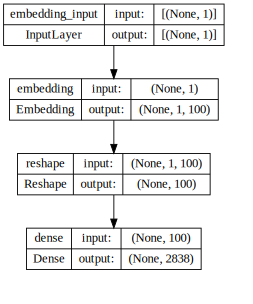

In [12]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))

print('vocab_size:', vocab_size)
print('dim:', dim)
skipgram.summary()
SVG(model_to_dot(skipgram, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [13]:
# Compile the Keras Model
skipgram.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the Skipgrams
for iteration in range(1, 10):
    loss, cnt = 0, 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
        cnt += 1
    print('iteration {}, avg. loss is {}'.format(iteration, loss/cnt))

iteration 1, avg. loss is 6.931620953388703
iteration 2, avg. loss is 6.124019554578341
iteration 3, avg. loss is 5.911676911574143
iteration 4, avg. loss is 5.76396924948081
iteration 5, avg. loss is 5.63218366525112
iteration 6, avg. loss is 5.5039536544604175
iteration 7, avg. loss is 5.38080204930061
iteration 8, avg. loss is 5.264777679947707
iteration 9, avg. loss is 5.154875824283331


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [14]:
word_vectors = skipgram.get_weights()[0]

def get_similarity(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [15]:
get_similarity('king', 'queen')

0.7769872

## <span style="color:orange">(100 คะแนน) ปรับจูนโมเดลให้ดีขึ้นเพื่อหาคำที่ใกล้เคียงกับคำที่ระบุ</span>
### * (50 คะแนน) ให้แสดงคำ 10 คำแรกที่ใกล้เคียงกับ queen มากที่สุดพร้อมค่าตัววัด
### * (50 คะแนน) ให้แสดงคำ 10 คำแรกที่ใกล้เคียงกับ queen น้อยที่สุดพร้อมค่าตัววัด  